 LArTPC Wire Signal Simulation
Config: config/cubic_wireplane_config.yaml, Data: mpvmpr.h5 (Event 0)
K=5, K_time=9, MaxHitsPad=100000
Successfully loaded detector config from config/cubic_wireplane_config.yaml
--- Creating Wire Signal Calculator (Factory Setup) ---
   Reading detector parameters...
   Parameters processed in 0.032 s
   Config: K_wire=5, K_time=9, Pad=100000
   Physics: Lifetime=10.0 ms, LongDiff=6.2 cm²/s, TransDiff=16.3 cm²/s
   Interpolation: 10 angles, 6 wire distances
--- Factory setup finished (0.03 s) ---

Triggering JIT compilation (if not cached)...
JIT compilation finished.

--- Processing Event 0 ---
Loaded 351187 steps from event 0.
Calculated recombined charge (shape: (351187,))
Padding event data...
Padding took 0.0623 s
Executing JIT calculator for the event...
Event calculation finished in 4.499 s
Event processing took 9.13 s total.

--- Creating Visualizations ---
Generating main visualization (all angles & distances)...
--- Starting Visualization (Whit

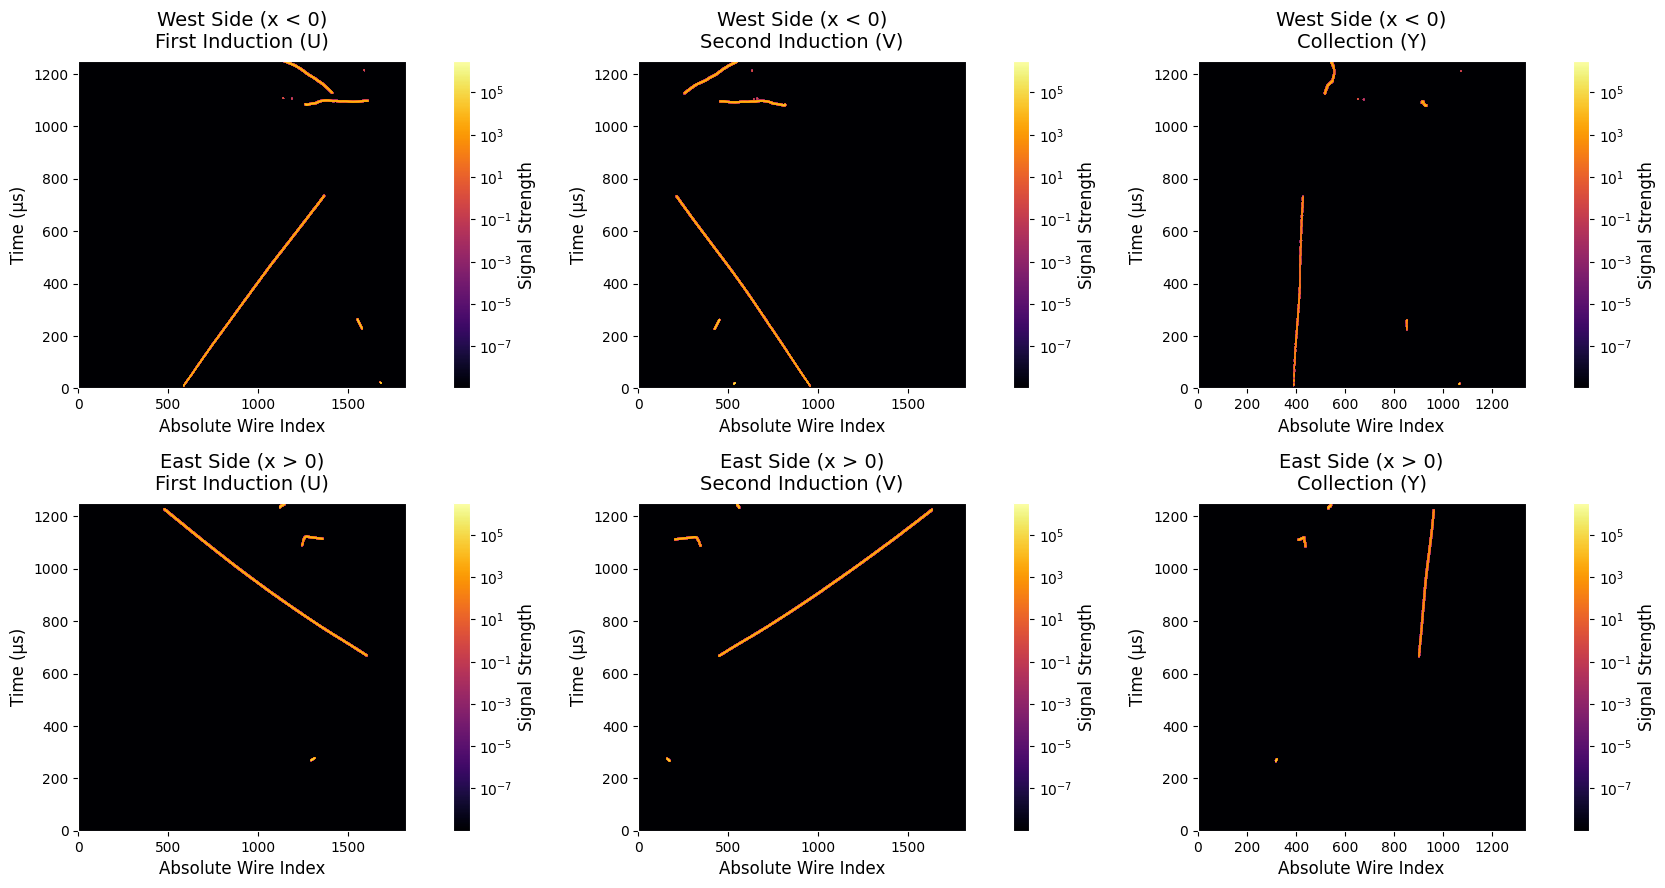

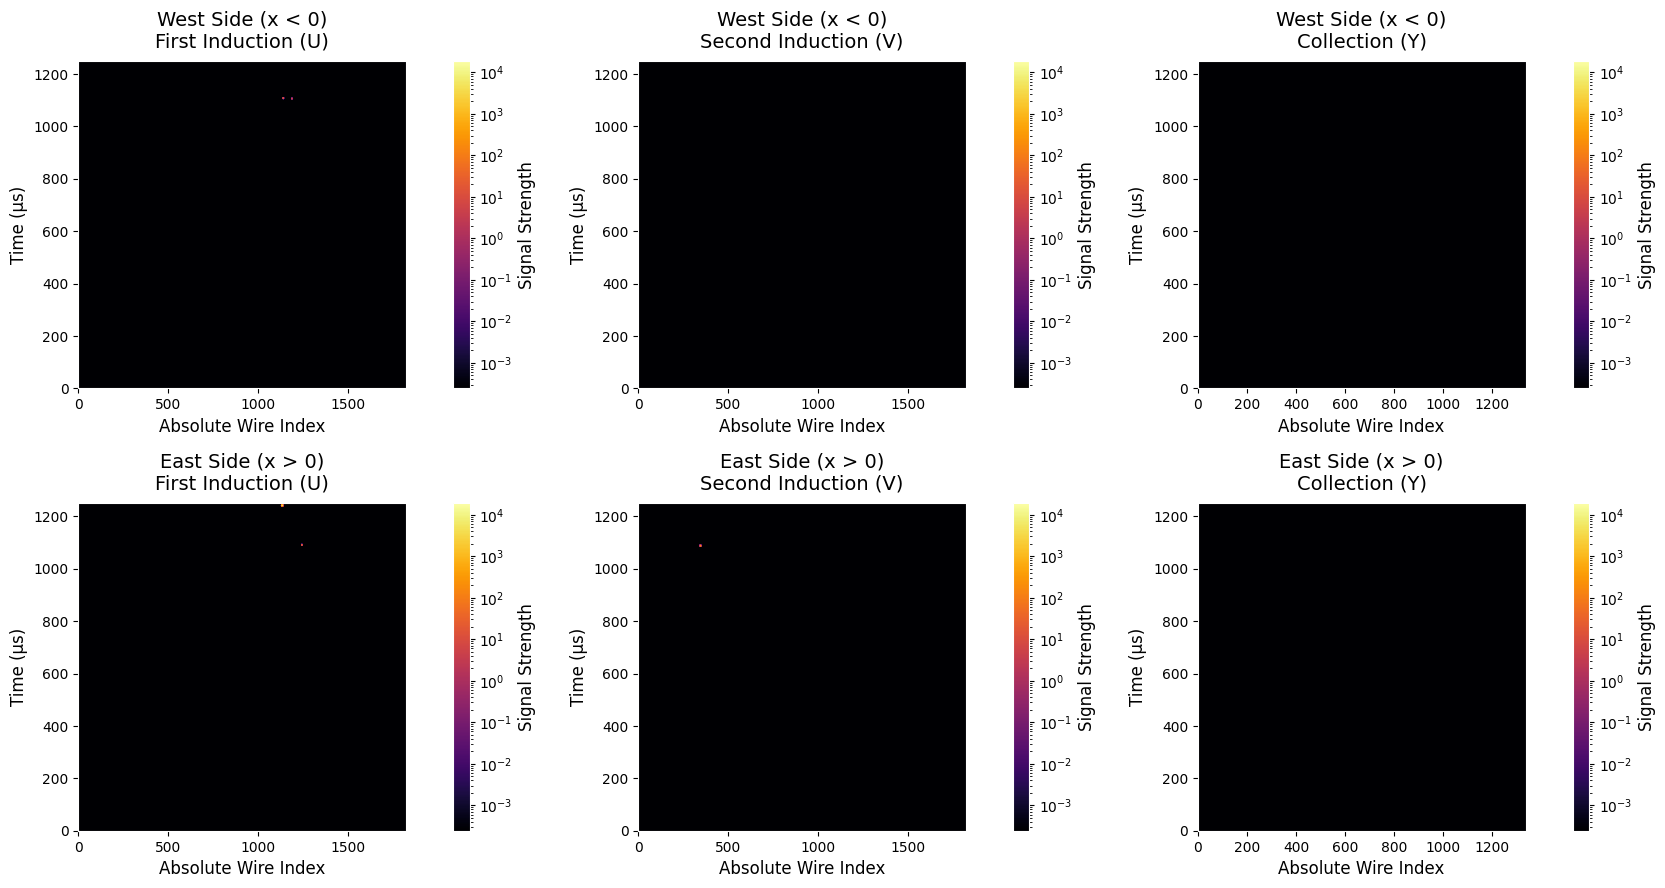

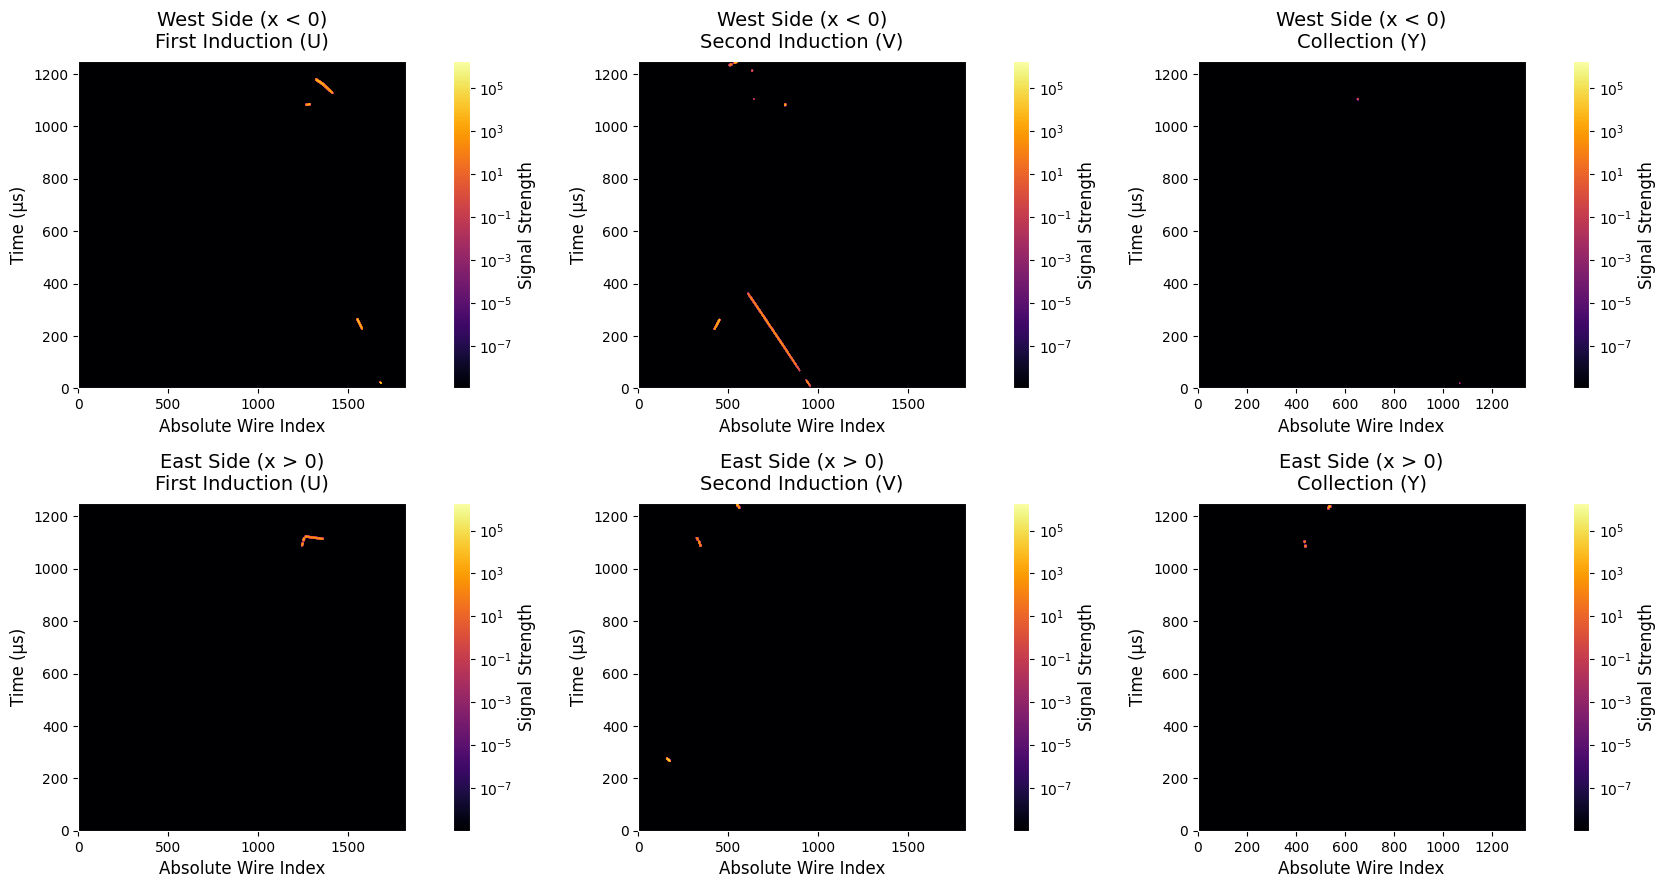

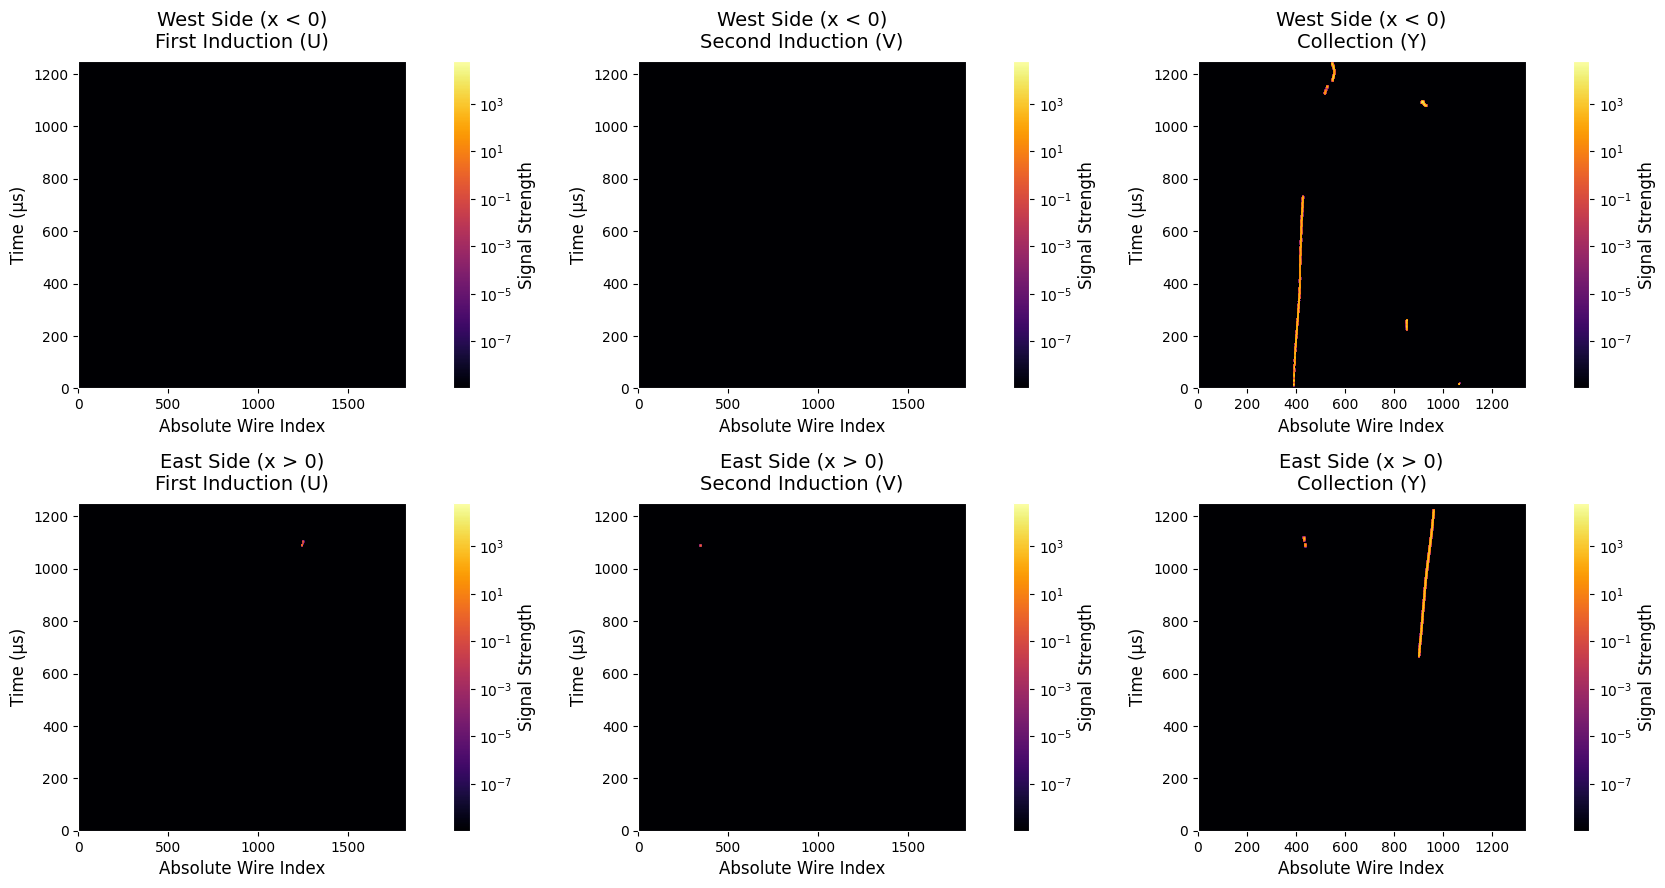

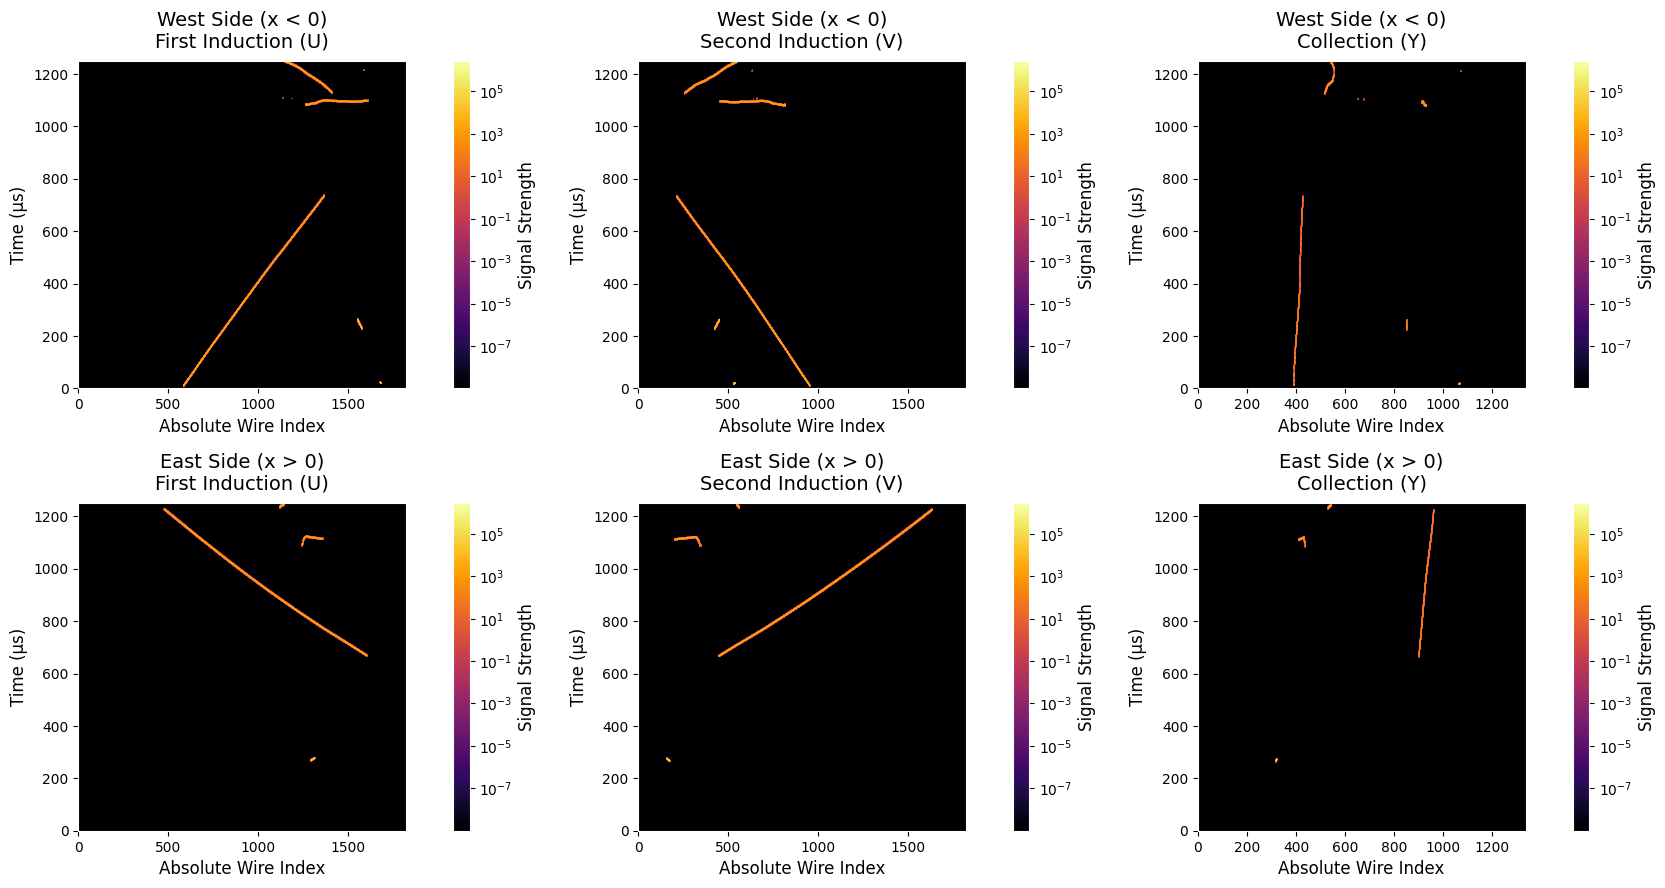

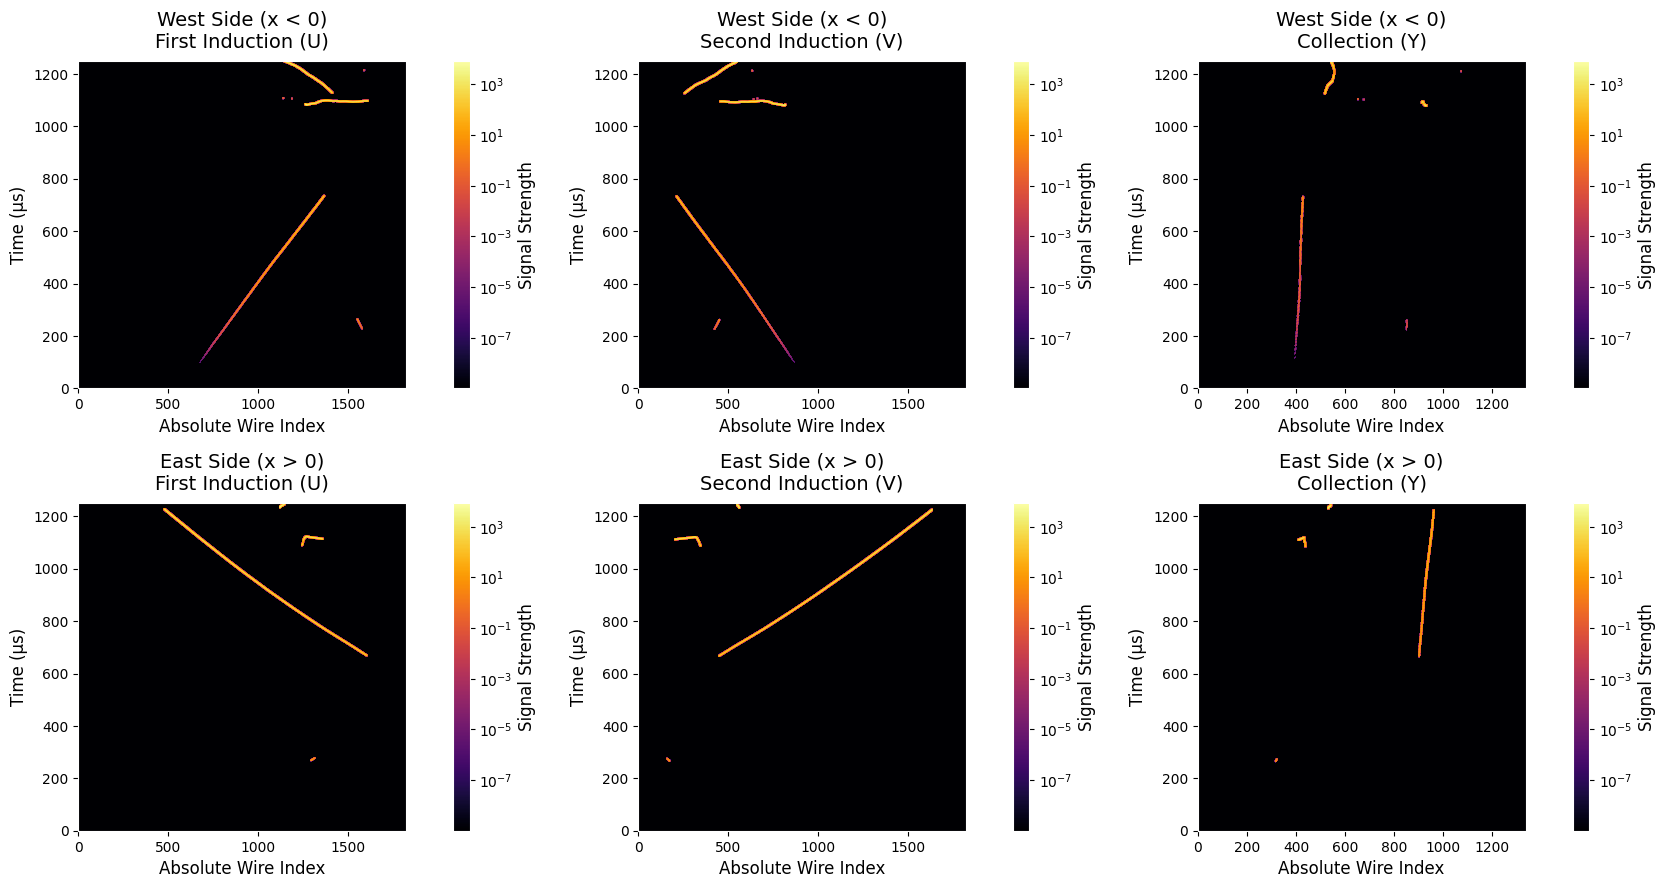

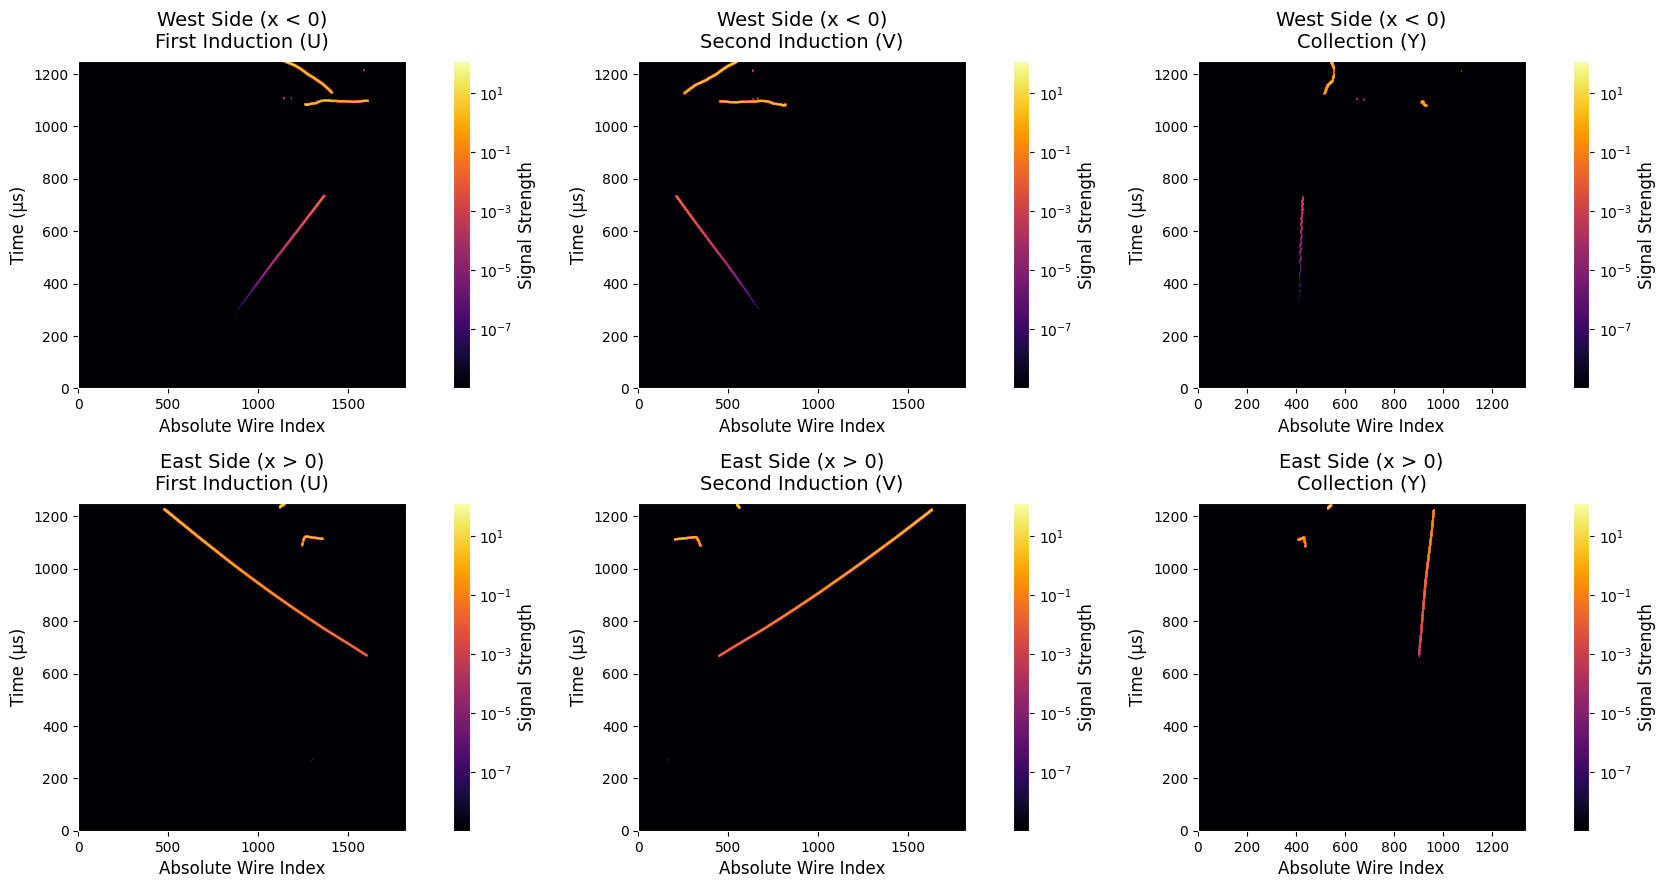

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
import time

# Import our modules
from tools.simulation import run_simulation
from tools.visualization import visualize_wire_signals

# Set JAX to use CPU
jax.config.update("jax_platform_name", "cpu")

if __name__ == "__main__":
    # Configuration
    config_path = "config/cubic_wireplane_config.yaml"
    data_path = "mpvmpr.h5"
    event_idx = 0
    K_wire = 5
    K_time = 9
    MAX_HITS_PADDING = 100_000

    # Create output directory if it doesn't exist
    os.makedirs("plots", exist_ok=True)

    # Run simulation
    wire_signals_dict, simulation_params = run_simulation(
        config_path, data_path, event_idx, K_wire, K_time, MAX_HITS_PADDING
    )

    # Create visualizations
    try:
        # Main visualization with all planes (summed over angles and distances)
        print("\n--- Creating Visualizations ---")

        # Create a summed version of the signals dictionary for all angles and distances
        summed_signals_dict = {}
        for (side_idx, plane_idx), signals in wire_signals_dict.items():
            # Sum over angles and wire distances dimensions
            summed_signals_dict[(side_idx, plane_idx)] = jnp.sum(signals, axis=(2, 3))

        # Use the visualize_wire_signals function for the main visualization
        print("Generating main visualization (all angles & distances)...")
        signal_fig = visualize_wire_signals(summed_signals_dict, simulation_params, figsize=(20, 10))
        signal_fig.savefig("plots/wire_signals_all_planes.png", dpi=500, bbox_inches='tight', facecolor='white')
        print(f"Main output figure saved to 'plots/wire_signals_all_planes.png'")

        # Visualize specific angle slices
        angle_indices = [0, len(simulation_params['angle_points'])//2, -1]
        for angle_idx in angle_indices:
            angle_value = simulation_params['angle_points'][angle_idx]
            print(f"Generating angle slice visualization (angle = {angle_value:.1f}°)...")

            # Create a signals dictionary for this angle slice
            angle_signals_dict = {}
            for (side_idx, plane_idx), signals in wire_signals_dict.items():
                # Sum over wire distances for this angle
                angle_signals_dict[(side_idx, plane_idx)] = jnp.sum(signals[:, :, angle_idx, :], axis=2)

            # Use the visualize_wire_signals function for this angle slice
            angle_fig = visualize_wire_signals(angle_signals_dict, simulation_params, figsize=(20, 10))
            angle_fig.savefig(f"plots/wire_signals_angle{angle_value:.0f}.png", dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Angle slice figure saved to 'plots/wire_signals_angle{angle_value:.0f}.png'")

        # Visualize specific distance slices
        dist_indices = [0, len(simulation_params['wire_distance_points'])//2, -1]
        for dist_idx in dist_indices:
            dist_value = simulation_params['wire_distance_points'][dist_idx]
            print(f"Generating distance slice visualization (distance = {dist_value:.1f} cm)...")

            # Create a signals dictionary for this distance slice
            dist_signals_dict = {}
            for (side_idx, plane_idx), signals in wire_signals_dict.items():
                # Sum over angles for this distance
                dist_signals_dict[(side_idx, plane_idx)] = jnp.sum(signals[:, :, :, dist_idx], axis=2)

            # Use the visualize_wire_signals function for this distance slice
            dist_fig = visualize_wire_signals(dist_signals_dict, simulation_params, figsize=(20, 10))
            dist_fig.savefig(f"plots/wire_signals_dist{dist_value:.1f}.png", dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Distance slice figure saved to 'plots/wire_signals_dist{dist_value:.1f}.png'")

        print("--- Visualization Finished ---")
    except Exception as e:
        print(f"\n--- An error occurred during visualization: ---")
        import traceback
        traceback.print_exc()

    print("="*60)
    print(" Simulation Script Finished ")
    print("="*60)

In [10]:
index = 0
wire_dist_slice = wire_signals_dict[(0, 0)][:,:,:,index]

print(wire_dist_slice.shape)
print(len(jnp.nonzero(wire_dist_slice)[0]))

(1823, 2501, 10)
1021


In [ ]:
import timeit
import time
import numpy as np
import jax
import jax.numpy as jnp
import yaml
import os

# Import missing functions from the tools modules
from tools.geometry import generate_detector
from tools.loader import load_particle_step_data
from tools.recombination import recombine_steps

# use cpu
# jax.config.update("jax_platform_name", "cpu")

def permute_step_data(step_data):
    """Permutes the order of steps using NumPy instead of JAX."""
    if not step_data or 'position' not in step_data or step_data['position'].shape[0] == 0:
        return step_data  # Return unchanged if empty

    num_steps = step_data['position'].shape[0]
    perm_indices = np.random.permutation(num_steps)

    permuted_data = {}
    for k, v in step_data.items():
        if isinstance(v, (np.ndarray, jnp.ndarray)) and v.shape[0] == num_steps:
            permuted_data[k] = v[perm_indices]
        else:
            permuted_data[k] = v

    return permuted_data

def run_timing_analysis(config_path, data_path, event_idx,
                        num_sim_runs, num_warmup_runs,
                        k_wire, k_time, max_hits_pad):
    """Simplified timing analysis function with proper JAX synchronization."""
    print(f"\n=== LArTPC Simulation Timing Analysis ===")
    print(f"Config: {config_path}, Data: {data_path}, Event: {event_idx}")
    print(f"K_wire: {k_wire}, K_time: {k_time}, Max Hits Pad: {max_hits_pad}")

    # Load Config - Using generate_detector instead of direct YAML loading
    try:
        detector_config = generate_detector(config_path)
        if detector_config is None:
            raise ValueError(f"Error loading detector configuration from {config_path}")
        print(f"Successfully loaded detector config from {config_path}")
    except Exception as e:
        print(f"Error loading config: {str(e)}")
        return None

    # Load Data
    try:
        initial_step_data = load_particle_step_data(data_path, event_idx)
        n_hits = initial_step_data['position'].shape[0]
        print(f"Loaded event with {n_hits} steps")

        # Ensure event size is within padding limit
        if n_hits > max_hits_pad:
            print(f"Event too large: {n_hits} > {max_hits_pad}")
            print(f"Will truncate to first {max_hits_pad} hits")
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

    # Create JIT Calculator
    try:
        calculate_event_signals, params = create_wire_signal_calculator(
            detector_config, K_wire=k_wire, K_time=k_time, max_num_hits_pad=max_hits_pad
        )
        print("Created wire signal calculator")
    except Exception as e:
        print(f"Error creating calculator: {str(e)}")
        return None

    # Run Timing Tests
    recomb_times, padding_times, calc_times = [], [], []
    total_runs = num_warmup_runs + num_sim_runs

    for i in range(total_runs):
        is_warmup = i < num_warmup_runs
        run_type = "Warmup" if is_warmup else "Timed"
        print(f"\n{run_type} Run {i+1}/{total_runs}")

        try:
            # 1. Permute data using NumPy
            step_data_permuted = permute_step_data(initial_step_data)

            # 2. Recombination
            start_recomb = timeit.default_timer()
            recomb_charge = recombine_steps(step_data_permuted, detector_config)
            recomb_charge = jnp.asarray(recomb_charge, dtype=jnp.float32)
            # Properly wait for computation to complete
            recomb_charge = jax.block_until_ready(recomb_charge)
            t_recomb = timeit.default_timer() - start_recomb
            print(f"  Recombination: {t_recomb:.6f} s")

            # 3. Padding or Truncating
            start_padding = timeit.default_timer()
            if max_hits_pad >= n_hits:
                # Pad arrays if max_hits_pad is greater than or equal to n_hits
                pad_width = max_hits_pad - n_hits
                valid_hit_mask_padded = jnp.arange(max_hits_pad) < n_hits
                charge_padded = jnp.pad(recomb_charge, (0, pad_width), constant_values=0.0)
                positions_mm_padded = jnp.pad(step_data_permuted['position'],
                                             ((0, pad_width), (0, 0)), constant_values=0.0)

                # Extract theta and phi from step_data (matching the main simulation)
                event_theta = jnp.asarray(step_data_permuted.get('theta', jnp.zeros((n_hits,))), dtype=jnp.float32)
                event_phi = jnp.asarray(step_data_permuted.get('phi', jnp.zeros((n_hits,))), dtype=jnp.float32)

                # Pad theta and phi arrays
                theta_padded = jnp.pad(event_theta, (0, pad_width), constant_values=0.0)
                phi_padded = jnp.pad(event_phi, (0, pad_width), constant_values=0.0)
            else:
                # Truncate arrays if max_hits_pad is less than n_hits
                # First create a valid hit mask without loading full array
                valid_hit_mask_padded = jnp.ones(max_hits_pad, dtype=bool)

                # Only load and convert the truncated portion directly
                charge_padded = jnp.asarray(recomb_charge[:max_hits_pad], dtype=jnp.float32)
                positions_mm_padded = jnp.asarray(step_data_permuted['position'][:max_hits_pad], dtype=jnp.float32)

                # Extract only the needed subset of theta and phi
                theta_subset = step_data_permuted.get('theta', None)
                if theta_subset is not None:
                    theta_padded = jnp.asarray(theta_subset[:max_hits_pad], dtype=jnp.float32)
                else:
                    theta_padded = jnp.zeros(max_hits_pad, dtype=jnp.float32)

                phi_subset = step_data_permuted.get('phi', None)
                if phi_subset is not None:
                    phi_padded = jnp.asarray(phi_subset[:max_hits_pad], dtype=jnp.float32)
                else:
                    phi_padded = jnp.zeros(max_hits_pad, dtype=jnp.float32)

            # Properly wait for computation to complete
            positions_mm_padded, charge_padded, valid_hit_mask_padded, theta_padded, phi_padded = jax.block_until_ready(
                (positions_mm_padded, charge_padded, valid_hit_mask_padded, theta_padded, phi_padded)
            )
            t_padding = timeit.default_timer() - start_padding
            print(f"  Padding:       {t_padding:.6f} s")

            # 4. Full Calculation
            start_calc = timeit.default_timer()
            wire_signals = calculate_event_signals(
                positions_mm_padded, charge_padded, valid_hit_mask_padded, theta_padded, phi_padded
            )
            # Wait for all computations to complete properly
            wire_signals = jax.block_until_ready(wire_signals)
            t_calc = timeit.default_timer() - start_calc
            print(f"  JIT Calc:      {t_calc:.6f} s")

            # Store results if not warmup
            if not is_warmup:
                recomb_times.append(t_recomb)
                padding_times.append(t_padding)
                calc_times.append(t_calc)

        except Exception as e:
            print(f"Error in run {i+1}: {str(e)}")
            if not is_warmup:
                print("Continuing with remaining runs...")

    # Calculate statistics
    if recomb_times:
        recomb_mean, recomb_std = np.mean(recomb_times), np.std(recomb_times)
        padding_mean, padding_std = np.mean(padding_times), np.std(padding_times)
        calc_mean, calc_std = np.mean(calc_times), np.std(calc_times)
        total_mean = recomb_mean + padding_mean + calc_mean

        print("\n=== Timing Results ===")
        print(f"Recombination: {recomb_mean:.6f} ± {recomb_std:.6f} s")
        print(f"Padding:       {padding_mean:.6f} ± {padding_std:.6f} s")
        print(f"JIT Calc:      {calc_mean:.6f} ± {calc_std:.6f} s")
        print(f"Total:         {total_mean:.6f} s")

        return {
            "recomb": (recomb_mean, recomb_std),
            "padding": (padding_mean, padding_std),
            "calc": (calc_mean, calc_std),
            "total": total_mean,
            "n_hits": n_hits
        }
    else:
        print("No timing data collected")
        return None

# Example usage
if __name__ == "__main__":
    CONFIG_PATH = "config/cubic_wireplane_config.yaml"
    DATA_PATH = "mpvmpr.h5"
    EVENT_IDX = 0
    NUM_WARMUP_RUNS = 2    # Fewer warmup runs for quicker testing
    NUM_SIM_RUNS = 50       # Fewer simulation runs for quicker testing
    K_WIRE = 5
    K_TIME = 9
    MAX_HITS_PADDING = 5_000

    # Set random seed for reproducibility
    np.random.seed(42)

    results = run_timing_analysis(
        config_path=CONFIG_PATH,
        data_path=DATA_PATH,
        event_idx=EVENT_IDX,
        num_sim_runs=NUM_SIM_RUNS,
        num_warmup_runs=NUM_WARMUP_RUNS,
        k_wire=K_WIRE,
        k_time=K_TIME,
        max_hits_pad=MAX_HITS_PADDING
    )


=== LArTPC Simulation Timing Analysis ===
Config: config/cubic_wireplane_config.yaml, Data: mpvmpr.h5, Event: 0
K_wire: 5, K_time: 9, Max Hits Pad: 8000
Successfully loaded detector config from config/cubic_wireplane_config.yaml
Loaded event with 351187 steps
Event too large: 351187 > 8000
Will truncate to first 8000 hits
--- Creating Wire Signal Calculator (Factory Setup) ---
   Reading detector parameters...
   Parameters processed in 0.055 s
   Config: K_wire=5, K_time=9, Pad=8000
   Physics: Lifetime=10.0 ms, LongDiff=6.2 cm²/s, TransDiff=16.3 cm²/s
   Interpolation: 10 angles, 6 wire distances
--- Factory setup finished (0.05 s) ---
Created wire signal calculator

Warmup Run 1/52
  Recombination: 0.048059 s
  Padding:       0.103288 s
  JIT Calc:      1.309316 s

Warmup Run 2/52
  Recombination: 0.000933 s
  Padding:       0.002102 s
  JIT Calc:      0.000811 s

Timed Run 3/52
  Recombination: 0.000741 s
  Padding:       0.002448 s
  JIT Calc:      0.000823 s

Timed Run 4/52
  Re